# Random quantum circuit simulation

In this notebook, we demonstrate simulation of random checkerboard quantum circuits of variying depths. The aim is to track how fidelity decays for a fixed maximum MPS bond dimension.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

from mdopt.utils.utils import create_random_mpo, svd
from mdopt.mps.utils import create_simple_product_state
from mdopt.contractor.contractor import mps_mpo_contract

from examples.random_circuit.random_circuit import create_mpo, create_mpo_from_layer

In [2]:
PHYS_DIM = 2

circ_depths = [4, 6, 8, 10, 12, 14, 16, 18, 20]
bond_dims = [8, 10, 12, 14, 16, 18, 20, 22, 24]
num_qubits = [27]

tails = {}
for NUM_QUBITS in num_qubits:
    for BOND_DIM in bond_dims:
        for NUM_LAYERS_CIRC in tqdm(circ_depths):
            tails_iter = []
            state = create_simple_product_state(
                num_sites=NUM_QUBITS,
                phys_dim=PHYS_DIM,
                which="0",
                form="Right-canonical",
                tolerance=np.inf,
            )

            for k in range(NUM_LAYERS_CIRC):
                layer = unitary_group.rvs(
                    PHYS_DIM**2, size=NUM_QUBITS // PHYS_DIM - k % 2
                )
                mpo = create_mpo_from_layer(layer)
                state = mps_mpo_contract(
                    mps=state,
                    mpo=mpo,
                    start_site=k % 2,
                    renormalise=True,
                    chi_max=1e4,
                    cut=1e-12,
                    inplace=False,
                    result_to_explicit=False,
                )

                state, errors = state.compress(
                    chi_max=BOND_DIM,
                    cut=1e-12,
                    renormalise=True,
                    strategy="svd",
                    return_truncation_errors=True,
                )

                fidels = [1 - error for error in errors]
                tails_iter.append(np.prod(fidels))

            tails[
                "numqubits"
                + str(NUM_QUBITS)
                + "_bonddim"
                + str(BOND_DIM)
                + "_circlayers"
                + str(NUM_LAYERS_CIRC)
            ] = tails_iter

100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


In [3]:
fidelities_total = {}
for chi in bond_dims:
    fidelities_total[chi] = [
        np.prod(
            tails[
                "numqubits"
                + str(NUM_QUBITS)
                + "_bonddim"
                + str(chi)
                + "_circlayers"
                + str(depth)
            ]
        )
        for depth in circ_depths
    ]

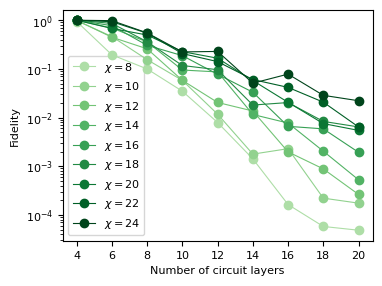

In [4]:
greens = plt.get_cmap("Greens")
plt.figure(figsize=(4, 3))
for qubits in num_qubits:
    for chi in bond_dims:
        try:
            plt.plot(
                circ_depths,
                fidelities_total[chi],
                "-o",
                label="$\chi=$" + str(chi),
                color=greens(chi / max(bond_dims)),
                linewidth=0.8,
                zorder=chi,
            )
        except:
            KeyError
plt.xticks(np.arange(4, 22, 2), fontsize=8)
plt.yticks(fontsize=8)
plt.legend(prop={"size": 8})
plt.ylabel("Fidelity", fontdict={"size": 8})
plt.xlabel("Number of circuit layers", fontdict={"size": 8})
plt.yscale("log")
plt.show()